# Summarizing Research Outputs - Base dataset

In [11]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time

# import the parquet library
import pyarrow.parquet as pq

# import model libraries
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [12]:
# load the data base_portfolio_reg1.parquet and base_lvwreturns_reg1.parquet

# portfolios
# regressions
portfolio1 = pd.read_parquet('market_portfolio_reg1.parquet') # all regressions
portfolio2 = pd.read_parquet('market_portfolio_class1.parquet') # classification - no Lasso
portfolio3 = pd.read_parquet('market_portfolio_class2.parquet') # classification - Lasso

portfolio4 = pd.read_parquet('market_portfolio_reg1_MSE.parquet')
portfolio5 = pd.read_parquet('market_portfolio_class1_MSE.parquet')
portfolio6 = pd.read_parquet('market_portfolio_class2_MSE.parquet')


In [13]:
portfolio1.head()

,date,RET,ME,y,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,decile_ols_default,position_ols_default,decile_ridge_reg_roll5,position_ridge_reg_roll5,decile_lasso_reg_roll5,position_lasso_reg_roll5,decile_DT_reg_roll5,position_DT_reg_roll5,decile_RF_reg_roll5,position_RF_reg_roll5
39215,1933-01-31,0.058824,456.750,1,0.589930,0.293012,0.391048,0.898343,0.882098,5,0,2,0,1.0,0,1,0,1,0
39216,1933-01-31,0.427451,18036.000,1,0.945905,0.671171,0.587175,1.000000,1.000000,9,1,9,1,6.0,0,3,0,5,0
39217,1933-01-31,-0.006993,1975.125,0,0.231157,0.086876,0.272193,0.000000,0.000000,0,-1,0,-1,0.0,-1,0,-1,0,-1
39218,1933-01-31,0.166667,241.500,1,0.862059,0.599736,0.524790,1.000000,1.000000,9,1,9,1,5.0,0,3,0,5,0
39219,1933-01-31,-0.058824,3304.000,0,-0.008792,-0.071598,0.153338,0.000000,0.000000,0,-1,0,-1,0.0,-1,0,-1,0,-1


## Prediction Evaluation (MAE, MSE, Accuracy) and Comparison of ML Algorithms

### Decile accuracy

In [14]:
# Assuming original portfolio DataFrames are named as such
dataframes = {
    'portfolio1': portfolio1,
    'portfolio2': portfolio2,
    'portfolio3': portfolio3, 
    'portfolio4': portfolio4,
    'portfolio5': portfolio5,
    'portfolio6': portfolio6 
}

# Define the cutoff date
cutoff_date = pd.to_datetime('1976-01-01')

# Filter each DataFrame to include only rows with dates before the cutoff date
for name, df in dataframes.items():
    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    # Filter based on the cutoff date
    dataframes[name] = df[df['date'] < cutoff_date]

# Loop through the dictionary to drop columns
for name, df in dataframes.items():
    # Find columns that start with "position" or "decile"
    columns_to_drop = [col for col in df.columns if col.startswith('decile')]
    # Drop these columns
    df.drop(columns=columns_to_drop, inplace=True)
    # Update the dictionary with the modified DataFrame
    dataframes[name] = df

# Columns to be dropped
columns_to_drop = ['date', 'RET', 'ME']


# Loop through the dictionary, skipping the first item
for name, df in list(dataframes.items()):  # [1:] skips the first item
    # Check if DataFrame contains the columns to be dropped
    cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    # Drop the columns if present
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)


# keep only predictions for the top and bottom deciles
for portfolio_name, df in dataframes.items():
    for col in df.columns:
        # If column does not start with "position_", check for a corresponding "position_" column
        if not col.startswith("position_"):
            position_col = f"position_{col}"
            if position_col in df.columns:
                # Replace model's value with NaN where position is 0
                df.loc[df[position_col] == 0, col] = np.nan
    # Drop columns starting with "position"
    df.drop(columns=[col for col in df.columns if col.startswith("position_")], inplace=True)
    
    # Update the dictionary with the modified dataframe
    dataframes[portfolio_name] = df



# Now, dataframes['portfolio1'], dataframes['portfolio2'], and dataframes['portfolio3'] have the columns dropped
# If you need to work directly with the modified portfolio1, portfolio2, and portfolio3, you can extract them like so:
portfolio1, portfolio2, portfolio3, portfolio4, portfolio5, portfolio6 = dataframes.values()

c:\Users\tomta\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\Users\tomta\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
c:\Users\tomta\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [15]:
metrics_decile = pd.DataFrame(columns=['Accuracy', 'MAE', 'MSE'])

def calculate_accuracy(y_true, y_pred):
    # Exclude NaN values from both y_true and y_pred
    valid_indices = ~y_pred.isna()
    y_true_valid = y_true[valid_indices]
    y_pred_valid = y_pred[valid_indices]
    y_pred_class = (y_pred_valid >= 0.5).astype(int)
    accuracy = np.mean(y_true_valid == y_pred_class)
    return accuracy

# Loop over each portfolio DataFrame
for name, portfolio in dataframes.items():
    y = portfolio['y']
    for column in portfolio.columns:
        if column == 'y':
            continue  # Skip the 'y' column

        # Calculate metrics, excluding NaN values
        valid_indices = ~portfolio[column].isna()
        if valid_indices.sum() > 0:  # Proceed only if there are non-NaN predictions
            accuracy = calculate_accuracy(y[valid_indices], portfolio[column][valid_indices])
            mae = mean_absolute_error(y[valid_indices], portfolio[column][valid_indices])
            mse = mean_squared_error(y[valid_indices], portfolio[column][valid_indices])

            # Store metrics in the DataFrame
            metrics_decile.loc[column] = [accuracy, mae, mse]
        else:
            # Handle the case where all predictions are NaN
            metrics_decile.loc[column] = [np.nan, np.nan, np.nan]

# Display the DataFrame with the calculated metrics
metrics_decile.head(20)

,Accuracy,MAE,MSE
ols_default,0.963131,0.238534,0.107924
ridge_reg_roll5,0.953734,0.236883,0.106889
lasso_reg_roll5,0.859492,0.373812,0.154929
DT_reg_roll5,0.966372,0.049248,0.024930
RF_reg_roll5,0.969338,0.041895,0.021335
base_ols_default,0.951408,0.248550,0.108347
ridge_clas_roll5,0.974079,0.033297,0.018236
DT_class_roll5,0.954484,0.079607,0.040502
RF_class_roll5,0.993133,0.036936,0.006691
lasso_clas_roll5,0.976917,0.036613,0.017779


In [16]:
# display only rows where index = 'ridge_reg_roll5','ridge_clas_roll5_AC', 'ridge_clas_roll5_decAC', 'RF_class_roll5_AC', 'RF_reg_exp', 'ols_default'
print_metrics = ['RF_reg_roll5_MSE', 'RF_class_roll5',  'DT_class_roll5_MSE', 'base_ols_default', 'lasso_clas_roll5']

metrics_decile[['Accuracy', 'MSE']].loc[print_metrics].sort_values(by='Accuracy', ascending=False).head(10)


,Accuracy,MSE
RF_class_roll5,0.993133,0.006691
lasso_clas_roll5,0.976917,0.017779
RF_reg_roll5_MSE,0.973051,0.017753
DT_class_roll5_MSE,0.966372,0.024930
base_ols_default,0.951408,0.108347


In [17]:
# Iterate over the row labels (index) of the metrics_decile DataFrame
for label in metrics_decile.index:
    # Determine 'type'
    if "reg" in label:
        metrics_decile.loc[label, 'type'] = 'reg'
    elif "clas" in label:
        metrics_decile.loc[label, 'type'] = 'class'
    elif "ols" in label:
        metrics_decile.loc[label, 'type'] = 'reg'
    else:
        metrics_decile.loc[label, 'type'] = 'class'

    
    # Determine 'metric'
    if label.endswith("MSE"):
        metrics_decile.loc[label, 'metric'] = 'mse'
    else:
        metrics_decile.loc[label, 'metric'] = 'acc'

    # Determine 'Algorithm'
    if "ridge" in label:
        metrics_decile.loc[label, 'algorithm'] = 'ridge'
    elif "DT" in label:
        metrics_decile.loc[label, 'algorithm'] = 'DT'
    elif "RF" in label:
        metrics_decile.loc[label, 'algorithm'] = 'RF'
    else:
        metrics_decile.loc[label, 'algorithm'] = 'other'


In [18]:
metrics_decile.sort_values(by='Accuracy', ascending=False, inplace=True)
metrics_decile.head(30)

,Accuracy,MAE,MSE,type,metric,algorithm
RF_class_roll5_MSE,0.993978,0.024975,0.005181,class,mse,RF
RF_class_roll5,0.993133,0.036936,0.006691,class,acc,RF
ridge_clas_roll5_MSE,0.982051,0.022893,0.014156,class,mse,ridge
lasso_clas_roll5_MSE,0.980234,0.024216,0.016482,class,mse,other
lasso_clas_roll5,0.976917,0.036613,0.017779,class,acc,other
ridge_clas_roll5,0.974079,0.033297,0.018236,class,acc,ridge
RF_reg_roll5_MSE,0.973051,0.034641,0.017753,reg,mse,RF
RF_reg_roll5,0.969338,0.041895,0.021335,reg,acc,RF
DT_reg_roll5,0.966372,0.049248,0.024930,reg,acc,DT
DT_class_roll5_MSE,0.966372,0.049248,0.024930,class,mse,DT


In [19]:
# First, generate dummy variables for categorical predictors
X = pd.get_dummies(metrics_decile[['type', 'metric', 'algorithm']], drop_first=True)
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Model 1: Accuracy as the dependent variable
y_accuracy = metrics_decile['Accuracy']
model_accuracy = sm.OLS(y_accuracy, X).fit()

# Model 2: MSE as the dependent variable
y_mse = metrics_decile['MSE']
model_mse = sm.OLS(y_mse, X).fit()

# Print the summary tables of both regressions
print("OLS Regression Model Summary (Dependent Variable: Accuracy)")
print(model_accuracy.summary())
print("\nOLS Regression Model Summary (Dependent Variable: MSE)")
print(model_mse.summary())

OLS Regression Model Summary (Dependent Variable: Accuracy)
                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     1.840
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.179
Time:                        17:11:49   Log-Likelihood:                 35.853
No. Observations:                  18   AIC:                            -59.71
Df Residuals:                      12   BIC:                            -54.36
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [20]:
# print average accuracy grouped by type and method
print(metrics_decile.groupby(['type', 'metric'])['Accuracy'].mean())

type   metric
class  acc       0.974653
       mse       0.980659
reg    acc       0.943912
       mse       0.927636
Name: Accuracy, dtype: float64


In [69]:
# print the average accuracy
print(metrics_decile['Accuracy'].mean())


0.9552926602256275


### Overall Accuracy

Drop useless columns from portfolio dataframes.

In [21]:
# load the data base_portfolio_reg1.parquet and base_lvwreturns_reg1.parquet

# portfolios
# regressions
portfolio1 = pd.read_parquet('market_portfolio_reg1.parquet') # all regressions
portfolio2 = pd.read_parquet('market_portfolio_class1.parquet') # classification - no Lasso
portfolio3 = pd.read_parquet('market_portfolio_class2.parquet') # classification - Lasso

portfolio4 = pd.read_parquet('market_portfolio_reg1_MSE.parquet')
portfolio5 = pd.read_parquet('market_portfolio_class1_MSE.parquet')
portfolio6 = pd.read_parquet('market_portfolio_class2_MSE.parquet')

In [22]:
# Assuming your DataFrames are already defined as portfolio1, portfolio2, and portfolio3
# Create a dictionary mapping names to DataFrame objects
dataframes = {
    'portfolio1': portfolio1,
    'portfolio2': portfolio2,
    'portfolio3': portfolio3, 
    'portfolio4': portfolio4,
    'portfolio5': portfolio5,
    'portfolio6': portfolio6
}

# Define the cutoff date
cutoff_date = pd.to_datetime('1976-01-01')

# Filter each DataFrame to include only rows with dates before the cutoff date
for name, df in dataframes.items():
    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    # Filter based on the cutoff date
    dataframes[name] = df[df['date'] < cutoff_date]

# Loop through the dictionary to drop columns
for name, df in dataframes.items():
    # Find columns that start with "position" or "decile"
    columns_to_drop = [col for col in df.columns if col.startswith('position') or col.startswith('decile')]
    # Drop these columns
    df.drop(columns=columns_to_drop, inplace=True)
    # Update the dictionary with the modified DataFrame
    dataframes[name] = df

# Columns to be dropped
columns_to_drop = ['date', 'RET', 'ME']


# Loop through the dictionary, skipping the first item
for name, df in list(dataframes.items()):  # [1:] skips the first item
    # Check if DataFrame contains the columns to be dropped
    cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    # Drop the columns if present
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)


# Now, dataframes['portfolio1'], dataframes['portfolio2'], and dataframes['portfolio3'] have the columns dropped
# If you need to work directly with the modified portfolio1, portfolio2, and portfolio3, you can extract them like so:
portfolio1, portfolio2, portfolio3, portfolio4, portfolio5, portfolio6 = dataframes.values()


c:\Users\tomta\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [23]:
# Initialize a DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'MAE', 'MSE'])

# Function to calculate accuracy assuming binary classification with threshold 0.5
def calculate_accuracy(y_true, y_pred):
    y_pred_class = (y_pred >= 0.5).astype(int)
    accuracy = np.mean(y_true == y_pred_class)
    return accuracy

# Loop over each portfolio DataFrame
for name, portfolio in dataframes.items():
    for column in portfolio.columns:
        if column == 'y' or column in metrics_df.index:
            continue  # Skip the 'y' column and any column already processed

        # Calculate metrics
        accuracy = calculate_accuracy(portfolio['y'], portfolio[column])
        mae = mean_absolute_error(portfolio['y'], portfolio[column])
        mse = mean_squared_error(portfolio['y'], portfolio[column])

        # Store metrics in the DataFrame
        metrics_df.loc[column] = [accuracy, mae, mse]

# Display the DataFrame with the calculated metrics
metrics_df.head()


,Accuracy,MAE,MSE
ols_default,0.867895,0.333954,0.140638
ridge_reg_roll5,0.826384,0.345800,0.152285
lasso_reg_roll5,0.778102,0.426219,0.192206
DT_reg_roll5,0.967694,0.050850,0.026024
RF_reg_roll5,0.967374,0.051020,0.025735


In [24]:
metrics_df[['Accuracy', 'MSE']].loc[print_metrics].sort_values(by='Accuracy', ascending=False).head(10)

,Accuracy,MSE
DT_class_roll5_MSE,0.967694,0.026024
RF_reg_roll5_MSE,0.967226,0.025543
RF_class_roll5,0.967115,0.032796
lasso_clas_roll5,0.907775,0.067872
base_ols_default,0.833637,0.150501


In [25]:
# Iterate over the row labels (index) of the DataFrame
for label in metrics_df.index:
    # Determine 'algorithm'
    if "reg" in label:
        metrics_df.loc[label, 'type'] = 'reg'
    elif "clas" in label:
        metrics_df.loc[label, 'type'] = 'class'
    elif "ols" in label:
        metrics_df.loc[label, 'type'] = 'reg'
    else:
        metrics_df.loc[label, 'type'] = 'class'
    
    
    # Determine 'metric'
    if label.endswith("MSE"):
        metrics_df.loc[label, 'metric'] = 'mse'
    else:
        metrics_df.loc[label, 'metric'] = 'acc'

    # Determine 'Algorithm'
    if "ridge" in label:
        metrics_df.loc[label, 'algorithm'] = 'ridge'
    elif "DT" in label:
        metrics_df.loc[label, 'algorithm'] = 'DT'
    elif "RF" in label:
        metrics_df.loc[label, 'algorithm'] = 'RF'
    else:
        metrics_df.loc[label, 'algorithm'] = 'other'


In [26]:
# sort the dataframe by MSE

metrics_df.sort_values(by='Accuracy', ascending=False, inplace=True)

metrics_df.head(30)

,Accuracy,MAE,MSE,type,metric,algorithm
DT_reg_roll5,0.967694,0.050850,0.026024,reg,acc,DT
DT_class_roll5_MSE,0.967694,0.050850,0.026024,class,mse,DT
DT_reg_roll5_MSE,0.967640,0.050824,0.026051,reg,mse,DT
RF_class_roll5_MSE,0.967451,0.093844,0.029482,class,mse,RF
RF_reg_roll5,0.967374,0.051020,0.025735,reg,acc,RF
RF_reg_roll5_MSE,0.967226,0.051336,0.025543,reg,mse,RF
RF_class_roll5,0.967115,0.111896,0.032796,class,acc,RF
DT_class_roll5,0.962701,0.064420,0.033257,class,acc,DT
lasso_clas_roll5_MSE,0.946228,0.095596,0.043579,class,mse,other
ridge_clas_roll5_MSE,0.928691,0.123054,0.054782,class,mse,ridge


In [27]:
# First, generate dummy variables for categorical predictors
X = pd.get_dummies(metrics_df[['type', 'metric', 'algorithm']], drop_first=True)
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Model 1: Accuracy as the dependent variable
y_accuracy = metrics_df['Accuracy']
model_tot_accuracy = sm.OLS(y_accuracy, X).fit()

# Model 2: MSE as the dependent variable
y_mse = metrics_df['MSE']
model_tot_mse = sm.OLS(y_mse, X).fit()

# Print the summary tables of both regressions
print("OLS Regression Model Summary (Dependent Variable: Accuracy)")
print(model_tot_accuracy.summary())


OLS Regression Model Summary (Dependent Variable: Accuracy)
                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     8.306
Date:                Wed, 06 Mar 2024   Prob (F-statistic):            0.00135
Time:                        17:11:54   Log-Likelihood:                 36.468
No. Observations:                  18   AIC:                            -60.94
Df Residuals:                      12   BIC:                            -55.59
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [28]:
print("\nOLS Regression Model Summary (Dependent Variable: MSE)")
print(model_tot_mse.summary())


OLS Regression Model Summary (Dependent Variable: MSE)
                            OLS Regression Results                            
Dep. Variable:                    MSE   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     8.377
Date:                Wed, 06 Mar 2024   Prob (F-statistic):            0.00130
Time:                        17:11:54   Log-Likelihood:                 38.287
No. Observations:                  18   AIC:                            -64.57
Df Residuals:                      12   BIC:                            -59.23
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [29]:
print(metrics_df.groupby(['type', 'metric'])['Accuracy'].mean())

type   metric
class  acc       0.931697
       mse       0.952516
reg    acc       0.873514
       mse       0.889006
Name: Accuracy, dtype: float64


## Portfolio Comparison in terms of returns

In [30]:
# returns
returns1 = pd.read_parquet('market_lvwreturns_reg1.parquet') # regression
returns2 = pd.read_parquet('market_lvwreturns_class1.parquet')  # no Lasso
returns3 = pd.read_parquet('market_lvwreturns_class2.parquet') # Lasso

returns4 = pd.read_parquet('market_lvwreturns_reg1_MSE.parquet')
returns5 = pd.read_parquet('market_lvwreturns_class1_MSE.parquet')
returns6 = pd.read_parquet('market_lvwreturns_class2_MSE.parquet')


### Handling the files

In [31]:
# drop the Mkt column from returns except for returns1

n_files = 6

# for "returns{i]" drop the Mkt column
for i in range(2, n_files + 1):
    returns = globals()[f'returns{i}']
    returns = returns.drop('Mkt', axis=1)
    globals()[f'returns{i}'] = returns

In [32]:
from functools import reduce

# Assuming your DataFrames are already loaded as returns1, returns2, ..., returns11
dataframes = [returns1, returns2, returns3, returns4, returns5, returns6]

# Use functools.reduce to merge all DataFrames on 'date'
log_ret = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dataframes)

# Check the first few rows of the merged DataFrame
log_ret.head()


,date,vwreturn_ols_default_x,vwreturn_ridge_reg_roll5,vwreturn_lasso_reg_roll5,vwreturn_DT_reg_roll5,vwreturn_RF_reg_roll5,Mkt,vwreturn_base_ols_default_x,vwreturn_ols_default_y,vwreturn_ridge_clas_roll5,vwreturn_DT_class_roll5,vwreturn_RF_class_roll5,vwreturn_lasso_clas_roll5,vwreturn_ols_default_x,vwreturn_ridge_reg_roll5_MSE,vwreturn_lasso_reg_roll5_MSE,vwreturn_DT_reg_roll5_MSE,vwreturn_RF_reg_roll5_MSE,vwreturn_base_ols_default_y,vwreturn_ols_default_y,vwreturn_ridge_clas_roll5_MSE,vwreturn_DT_class_roll5_MSE,vwreturn_RF_class_roll5_MSE,vwreturn_lasso_clas_roll5_MSE
0,1934-01-31,0.009170,0.004228,-0.024878,-0.004525,-0.002634,0.119115,0.029515,0.009170,0.001817,-0.004525,0.018274,0.005500,0.009170,0.005535,-0.024878,-0.004525,-0.002634,0.029515,0.009170,0.003762,-0.004525,0.006103,-0.006820
1,1934-02-28,0.008422,0.011540,0.006018,0.033193,0.033193,-0.025113,0.011875,0.008422,0.010703,0.034380,0.009791,0.008151,0.008422,0.009842,0.006018,0.033193,0.033193,0.011875,0.008422,0.001933,0.033193,0.011650,0.001651
2,1934-03-31,0.007692,0.007647,0.005009,0.014471,0.014502,0.001099,0.007702,0.007692,0.007729,0.015172,0.008603,0.007754,0.007692,0.007631,0.005009,0.014471,0.014502,0.007702,0.007692,0.008121,0.014471,0.009100,0.005520
3,1934-04-30,0.018335,0.018177,0.014962,0.029684,0.029998,-0.017960,0.015491,0.018335,0.018814,0.030212,0.009816,0.019403,0.018335,0.018218,0.014962,0.029684,0.029998,0.015491,0.018335,0.019528,0.029684,0.010235,0.018017
4,1934-05-31,0.023093,0.023994,0.024376,0.069124,0.069223,-0.075155,0.019078,0.023093,0.024180,0.069230,0.020746,0.024497,0.023093,0.024200,0.024376,0.069124,0.069223,0.019078,0.023093,0.025507,0.069124,0.013322,0.025477


In [33]:
# drop rows where date < 1976-01-01
log_ret = log_ret[log_ret['date'] >= '1976-01-01']


In [34]:
# Filter columns that do not end with "_x", "_y", or "_z"
filtered_columns = [col for col in log_ret.columns if not col.endswith(('_y', '_z'))]

# Select only the filtered columns from the DataFrame

log_ret = log_ret[filtered_columns]

# drop columns with duplicate names
log_ret = log_ret.loc[:,~log_ret.columns.duplicated()]


print(log_ret.columns)

Index(['date', 'vwreturn_ols_default_x', 'vwreturn_ridge_reg_roll5',
       'vwreturn_lasso_reg_roll5', 'vwreturn_DT_reg_roll5',
       'vwreturn_RF_reg_roll5', 'Mkt', 'vwreturn_base_ols_default_x',
       'vwreturn_ridge_clas_roll5', 'vwreturn_DT_class_roll5',
       'vwreturn_RF_class_roll5', 'vwreturn_lasso_clas_roll5',
       'vwreturn_ridge_reg_roll5_MSE', 'vwreturn_lasso_reg_roll5_MSE',
       'vwreturn_DT_reg_roll5_MSE', 'vwreturn_RF_reg_roll5_MSE',
       'vwreturn_ridge_clas_roll5_MSE', 'vwreturn_DT_class_roll5_MSE',
       'vwreturn_RF_class_roll5_MSE', 'vwreturn_lasso_clas_roll5_MSE'],
      dtype='object')


In [35]:
# Rename columns in 'log_ret' DataFrame
log_ret.rename(columns={col: col.replace('vwreturn', 'l') for col in log_ret.columns}, inplace=True)

log_ret.rename(columns={col: col.replace('_x', '') for col in log_ret.columns}, inplace=True)

# rename 'Mkt' column to 'l_Mkt'
log_ret.rename(columns={'Mkt': 'l_Mkt'}, inplace=True)

# Check the updated column names
print(log_ret.columns)

Index(['date', 'l_ols_default', 'l_ridge_reg_roll5', 'l_lasso_reg_roll5',
       'l_DT_reg_roll5', 'l_RF_reg_roll5', 'l_Mkt', 'l_base_ols_default',
       'l_ridge_clas_roll5', 'l_DT_class_roll5', 'l_RF_class_roll5',
       'l_lasso_clas_roll5', 'l_ridge_reg_roll5_MSE', 'l_lasso_reg_roll5_MSE',
       'l_DT_reg_roll5_MSE', 'l_RF_reg_roll5_MSE', 'l_ridge_clas_roll5_MSE',
       'l_DT_class_roll5_MSE', 'l_RF_class_roll5_MSE',
       'l_lasso_clas_roll5_MSE'],
      dtype='object')


In [36]:
# calculate cumulative sum of each column except for the date column and store in a new DataFrame cum_log_ret, keep the date column
log_ret.sort_values('date', inplace=True)
log_ret.set_index('date', inplace=True)

cum_log_ret = log_ret.cumsum()
cum_log_ret.head()

,l_ols_default,l_ridge_reg_roll5,l_lasso_reg_roll5,l_DT_reg_roll5,l_RF_reg_roll5,l_Mkt,l_base_ols_default,l_ridge_clas_roll5,l_DT_class_roll5,l_RF_class_roll5,l_lasso_clas_roll5,l_ridge_reg_roll5_MSE,l_lasso_reg_roll5_MSE,l_DT_reg_roll5_MSE,l_RF_reg_roll5_MSE,l_ridge_clas_roll5_MSE,l_DT_class_roll5_MSE,l_RF_class_roll5_MSE,l_lasso_clas_roll5_MSE
date,,,,,,,,,,,,,,,,,,,
1976-01-31,0.029901,0.028066,-0.080121,-0.000991,-0.000991,0.118938,0.038959,0.020819,-0.000991,0.022852,0.021440,0.030377,-0.080121,-0.000991,-0.000239,-0.002035,-0.000991,0.028420,-0.001327
1976-02-29,0.045608,0.048520,-0.057943,0.021992,0.021982,0.125516,0.058548,0.041026,0.022771,0.042100,0.045029,0.045782,-0.057943,0.021992,0.023398,0.001926,0.021992,0.049091,0.002354
1976-03-31,0.057129,0.059368,-0.052895,0.023816,0.023806,0.152353,0.069559,0.052802,0.035191,0.054382,0.049498,0.056935,-0.052895,0.023816,0.029528,0.004230,0.023816,0.059109,0.004724
1976-04-30,0.068188,0.070163,-0.049278,0.048441,0.048430,0.141595,0.078272,0.060548,0.059692,0.066481,0.057193,0.067639,-0.049278,0.048441,0.054058,0.011956,0.048441,0.070621,0.007477
1976-05-31,0.085745,0.087771,-0.043838,0.069311,0.074029,0.131848,0.096099,0.075714,0.085508,0.079339,0.072598,0.085346,-0.043838,0.069311,0.079816,0.026481,0.069311,0.085192,0.011449


### What methods perform the best

In [37]:
# calculate cumulative sum of each column except for the date column and store in a new DataFrame and keep only the last row
final_log_ret = cum_log_ret.iloc[-1]
final_log_ret.head() 

l_ols_default         8.911537
l_ridge_reg_roll5     9.090976
l_lasso_reg_roll5     2.638381
l_DT_reg_roll5       10.216358
l_RF_reg_roll5       11.773111
Name: 2022-07-31 00:00:00, dtype: float64

In [38]:
final_log_ret.tail() 

l_RF_reg_roll5_MSE        12.943043
l_ridge_clas_roll5_MSE     3.989854
l_DT_class_roll5_MSE      11.029973
l_RF_class_roll5_MSE       7.191899
l_lasso_clas_roll5_MSE     2.610915
Name: 2022-07-31 00:00:00, dtype: float64

In [39]:
# Convert final_log_ret Series to DataFrame and reset index
final_log_ret_df = final_log_ret.to_frame().reset_index()

# Rename the columns
final_log_ret_df.columns = ['model', 'total_cum_logret']

# Sort the DataFrame by 'total_cum_logret' in descending order
final_log_ret_df.sort_values(by='total_cum_logret', ascending=False, inplace=True)

# Check the first few rows of the updated DataFrame
print(final_log_ret_df.head())


                   model  total_cum_logret
14    l_RF_reg_roll5_MSE         12.943043
4         l_RF_reg_roll5         11.773111
16  l_DT_class_roll5_MSE         11.029973
13    l_DT_reg_roll5_MSE         11.025880
3         l_DT_reg_roll5         10.216358


In [40]:
# Add 'Type' column
final_log_ret_df['Type'] = final_log_ret_df['model'].apply(
    lambda x: 'reg' if 'reg' in x else ('class' if 'clas' in x else 'other')
)


# Add 'Metric' column
final_log_ret_df['Metric'] = final_log_ret_df['model'].apply(
    lambda x: 'mse' if x.endswith('MSE') else 'acc'
)

# Add 'Algorithm' column
final_log_ret_df['Algorithm'] = final_log_ret_df['model'].apply(
    lambda x: 'ridge' if 'ridge' in x else (
        'DT' if 'DT' in x else (
            'RF' if 'RF' in x else 'other'
        )
    )
)

# Check the first few rows to verify the new columns
final_log_ret_df.head()


,model,total_cum_logret,Type,Metric,Algorithm
14,l_RF_reg_roll5_MSE,12.943043,reg,mse,RF
4,l_RF_reg_roll5,11.773111,reg,acc,RF
16,l_DT_class_roll5_MSE,11.029973,class,mse,DT
13,l_DT_reg_roll5_MSE,11.025880,reg,mse,DT
3,l_DT_reg_roll5,10.216358,reg,acc,DT


In [41]:
# change the value of "Algoithm" column to reg if value in model column contains "ols"
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('ols'), 'Algorithm'] = 'ols'
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('ols'), 'Type'] = 'reg'

# change the value of "Algoithm" column to class if value in model column contains "logit"
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('logit'), 'Type'] = 'class'
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('logit'), 'Algorithm'] = 'logit'

In [42]:
# sort the final_log_ret_df DataFrame by 'total_cum_logret' in descending order

final_log_ret_df.sort_values('total_cum_logret', ascending=False, inplace=True)

final_log_ret_df.head(10)

,model,total_cum_logret,Type,Metric,Algorithm
14,l_RF_reg_roll5_MSE,12.943043,reg,mse,RF
4,l_RF_reg_roll5,11.773111,reg,acc,RF
16,l_DT_class_roll5_MSE,11.029973,class,mse,DT
13,l_DT_reg_roll5_MSE,11.025880,reg,mse,DT
3,l_DT_reg_roll5,10.216358,reg,acc,DT
1,l_ridge_reg_roll5,9.090976,reg,acc,ridge
6,l_base_ols_default,9.076506,reg,acc,ols
11,l_ridge_reg_roll5_MSE,8.926779,reg,mse,ridge
0,l_ols_default,8.911537,reg,acc,ols
9,l_RF_class_roll5,8.592562,class,acc,RF


In [43]:
# print the 5 best performing models as a list

best_models = final_log_ret_df['model'].head(6).tolist()
print(best_models)

['l_RF_reg_roll5_MSE', 'l_RF_reg_roll5', 'l_DT_class_roll5_MSE', 'l_DT_reg_roll5_MSE', 'l_DT_reg_roll5', 'l_ridge_reg_roll5']


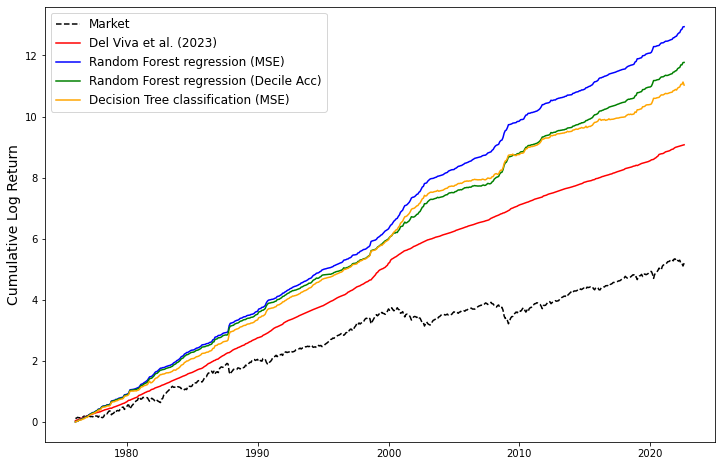

In [44]:
# Plot cumulative log returns for best_models


from matplotlib import lines


plt.figure(figsize=(12, 8))
#for model in best_models:
#    plt.plot(cum_log_ret.index, cum_log_ret[model], label=model)

#plot the 'l_Mkt' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_Mkt'], label='Market', color='black', linestyle='dashed')

# plot 'l_ols_default' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_base_ols_default'], label='Del Viva et al. (2023)', color='red')

# l_RF_reg_roll5_MSE from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_RF_reg_roll5_MSE'], label='Random Forest regression (MSE)', color='blue')

# l_RF_reg_roll5 from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_RF_reg_roll5'], label='Random Forest regression (Decile Acc)', color='green')

# plot l_DT_class_roll5_MSE from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_DT_class_roll5_MSE'], label='Decision Tree classification (MSE)', color='orange')




plt.ylabel('Cumulative Log Return', fontsize=14)
plt.legend(fontsize=12)
plt.show()


### From log returns to normal returns

In [45]:
# Copy the DataFrame to keep the date column unchanged
normal_ret = log_ret.copy()

# Apply the conversion to all columns except 'date'
for col in normal_ret.columns:
    if col != 'date':
        normal_ret[col] = np.exp(normal_ret[col]) - 1

# Display the head of the updated DataFrame to verify the changes
normal_ret.head()

,l_ols_default,l_ridge_reg_roll5,l_lasso_reg_roll5,l_DT_reg_roll5,l_RF_reg_roll5,l_Mkt,l_base_ols_default,l_ridge_clas_roll5,l_DT_class_roll5,l_RF_class_roll5,l_lasso_clas_roll5,l_ridge_reg_roll5_MSE,l_lasso_reg_roll5_MSE,l_DT_reg_roll5_MSE,l_RF_reg_roll5_MSE,l_ridge_clas_roll5_MSE,l_DT_class_roll5_MSE,l_RF_class_roll5_MSE,l_lasso_clas_roll5_MSE
date,,,,,,,,,,,,,,,,,,,
1976-01-31,0.030353,0.028463,-0.076995,-0.000991,-0.000991,0.1263,0.039728,0.021037,-0.000991,0.023115,0.021671,0.030843,-0.076995,-0.000991,-0.000239,-0.002033,-0.000991,0.028828,-0.001326
1976-02-29,0.015831,0.020665,0.022425,0.023250,0.023239,0.0066,0.019782,0.020413,0.024047,0.019435,0.023870,0.015524,0.022425,0.023250,0.023919,0.003969,0.023250,0.020886,0.003688
1976-03-31,0.011587,0.010907,0.005061,0.001826,0.001825,0.0272,0.011072,0.011845,0.012497,0.012357,0.004478,0.011215,0.005061,0.001826,0.006148,0.002307,0.001826,0.010069,0.002372
1976-04-30,0.011121,0.010854,0.003623,0.024930,0.024930,-0.0107,0.008751,0.007777,0.024804,0.012172,0.007725,0.010762,0.003623,0.024930,0.024834,0.007755,0.024930,0.011578,0.002757
1976-05-31,0.017712,0.017764,0.005455,0.021090,0.025930,-0.0097,0.017987,0.015281,0.026151,0.012942,0.015524,0.017865,0.005455,0.021090,0.026093,0.014631,0.021090,0.014677,0.003980


In [46]:
normal_ret.rename(columns={col: col.replace('l_', '') if col != 'date' else col for col in normal_ret.columns}, inplace=True)
normal_ret.head()

,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE
date,,,,,,,,,,,,,,,,,,,
1976-01-31,0.030353,0.028463,-0.076995,-0.000991,-0.000991,0.1263,0.039728,0.021037,-0.000991,0.023115,0.021671,0.030843,-0.076995,-0.000991,-0.000239,-0.002033,-0.000991,0.028828,-0.001326
1976-02-29,0.015831,0.020665,0.022425,0.023250,0.023239,0.0066,0.019782,0.020413,0.024047,0.019435,0.023870,0.015524,0.022425,0.023250,0.023919,0.003969,0.023250,0.020886,0.003688
1976-03-31,0.011587,0.010907,0.005061,0.001826,0.001825,0.0272,0.011072,0.011845,0.012497,0.012357,0.004478,0.011215,0.005061,0.001826,0.006148,0.002307,0.001826,0.010069,0.002372
1976-04-30,0.011121,0.010854,0.003623,0.024930,0.024930,-0.0107,0.008751,0.007777,0.024804,0.012172,0.007725,0.010762,0.003623,0.024930,0.024834,0.007755,0.024930,0.011578,0.002757
1976-05-31,0.017712,0.017764,0.005455,0.021090,0.025930,-0.0097,0.017987,0.015281,0.026151,0.012942,0.015524,0.017865,0.005455,0.021090,0.026093,0.014631,0.021090,0.014677,0.003980


## Bringing in the market data, factors

In [47]:
# load csv from "C:\Users\tomta\Tomas\School\03_Magistr\02_Business Analytics\10_BA_Thesis\03_Modeling\02_Sign prediction\FF3_clean.csv"
ff3 = pd.read_csv('C:\\Users\\tomta\\Tomas\\School\\03_Magistr\\02_Business Analytics\\10_BA_Thesis\\03_Modeling\\02_Sign prediction\\FF3_clean.csv')
ff5 = pd.read_csv('C:\\Users\\tomta\\Tomas\\School\\03_Magistr\\02_Business Analytics\\10_BA_Thesis\\03_Modeling\\02_Sign prediction\\FF5_clean.csv')

In [48]:
ff3.head()

,date,Mkt-RF,SMB,HML,RF
0,1926-07-31,2.96,-2.56,-2.43,0.22
1,1926-08-31,2.64,-1.17,3.82,0.25
2,1926-09-30,0.36,-1.40,0.13,0.23
3,1926-10-31,-3.24,-0.09,0.70,0.32
4,1926-11-30,2.53,-0.10,-0.51,0.31


In [49]:
ff3['date'] = pd.to_datetime(ff3['date'])
ff5['date'] = pd.to_datetime(ff5['date'])

# rename SMB and HML columns in ff3 to SMB3 and HML3
ff3.rename(columns={'SMB': 'SMB3', 'HML': 'HML3'}, inplace=True)

# rename SMB and HML columns in ff5 to SMB5 and HML5 and RMW and CMA to RMW5 and CMA5
ff5.rename(columns={'SMB': 'SMB5', 'HML': 'HML5', 'RMW': 'RMW5', 'CMA': 'CMA5'}, inplace=True)

# drop the Mkt-RF and RF column from ff5
ff5 = ff5.drop(['Mkt-RF', 'RF'], axis=1)

# divide all columns in ff3 by 100 (except for the date column)
ff3.iloc[:, 1:] = ff3.iloc[:, 1:] / 100


# merge the ff3 and ff5 DataFrames to one dataframe
factors = pd.merge(ff3, ff5, on='date', how='left')

factors.tail()

,date,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
1165,2023-08-31,-0.0239,-0.0316,-0.0106,0.0045,-0.0365,-0.0106,0.0343,-0.0237
1166,2023-09-30,-0.0524,-0.0251,0.0152,0.0043,-0.0180,0.0152,0.0186,-0.0083
1167,2023-10-31,-0.0319,-0.0387,0.0019,0.0047,-0.0404,0.0019,0.0246,-0.0066
1168,2023-11-30,0.0884,-0.0002,0.0164,0.0044,-0.0012,0.0164,-0.0391,-0.0100
1169,2023-12-31,0.0485,0.0635,0.0494,0.0043,0.0732,0.0494,-0.0307,0.0132


In [50]:
models = normal_ret.columns
models.drop('Mkt')

Index(['ols_default', 'ridge_reg_roll5', 'lasso_reg_roll5', 'DT_reg_roll5',
       'RF_reg_roll5', 'base_ols_default', 'ridge_clas_roll5',
       'DT_class_roll5', 'RF_class_roll5', 'lasso_clas_roll5',
       'ridge_reg_roll5_MSE', 'lasso_reg_roll5_MSE', 'DT_reg_roll5_MSE',
       'RF_reg_roll5_MSE', 'ridge_clas_roll5_MSE', 'DT_class_roll5_MSE',
       'RF_class_roll5_MSE', 'lasso_clas_roll5_MSE'],
      dtype='object')

In [51]:
# merge ff3 to normal_ret on 'date'
normal_ret = normal_ret.merge(factors, on='date', how='inner')

normal_ret.head()

,date,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
0,1976-01-31,0.030353,0.028463,-0.076995,-0.000991,-0.000991,0.1263,0.039728,0.021037,-0.000991,0.023115,0.021671,0.030843,-0.076995,-0.000991,-0.000239,-0.002033,-0.000991,0.028828,-0.001326,0.1216,0.0481,0.0863,0.0047,0.0634,0.0863,-0.0179,0.0228
1,1976-02-29,0.015831,0.020665,0.022425,0.023250,0.023239,0.0066,0.019782,0.020413,0.024047,0.019435,0.023870,0.015524,0.022425,0.023250,0.023919,0.003969,0.023250,0.020886,0.003688,0.0032,0.0706,0.0587,0.0034,0.0799,0.0587,-0.0264,0.0387
2,1976-03-31,0.011587,0.010907,0.005061,0.001826,0.001825,0.0272,0.011072,0.011845,0.012497,0.012357,0.004478,0.011215,0.005061,0.001826,0.006148,0.002307,0.001826,0.010069,0.002372,0.0232,-0.0116,-0.0012,0.0040,-0.0138,-0.0012,-0.0033,0.0096
3,1976-04-30,0.011121,0.010854,0.003623,0.024930,0.024930,-0.0107,0.008751,0.007777,0.024804,0.012172,0.007725,0.010762,0.003623,0.024930,0.024834,0.007755,0.024930,0.011578,0.002757,-0.0149,-0.0011,-0.0016,0.0042,0.0008,-0.0016,0.0040,-0.0110
4,1976-05-31,0.017712,0.017764,0.005455,0.021090,0.025930,-0.0097,0.017987,0.015281,0.026151,0.012942,0.015524,0.017865,0.005455,0.021090,0.026093,0.014631,0.021090,0.014677,0.003980,-0.0134,-0.0123,-0.0136,0.0037,-0.0110,-0.0136,0.0246,-0.0141


In [52]:
normal_ret.tail()

,date,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
554,2022-03-31,0.013454,0.013564,0.002295,0.015193,0.015193,0.0306,0.014639,0.013753,-0.016202,0.013826,0.013774,0.013718,0.002295,0.015193,0.015480,0.002246,0.015193,0.013834,0.002250,0.0305,-0.0161,-0.0181,0.0001,-0.0217,-0.0181,-0.0153,0.0314
555,2022-04-30,0.010321,0.009996,0.005953,0.088647,0.088647,-0.0945,0.010195,0.011051,0.088647,0.015805,0.011716,0.009619,0.005953,0.088647,0.088647,0.011621,0.088647,0.020885,0.011661,-0.0946,-0.0139,0.0617,0.0001,-0.0039,0.0617,0.0352,0.0589
556,2022-05-31,0.009911,0.009780,0.002204,0.001195,0.001195,-0.0031,0.010948,0.010744,0.001195,0.011058,0.010273,0.010080,0.002204,0.001195,0.026663,0.008969,0.001195,0.017490,0.008988,-0.0034,-0.0183,0.0839,0.0003,-0.0006,0.0839,0.0156,0.0397
557,2022-06-30,0.007437,0.007688,0.006251,0.078736,0.078736,-0.0837,0.005976,0.007865,0.078736,0.007082,0.007985,0.007902,0.006251,0.078736,0.081993,0.007614,0.078736,0.017306,0.007405,-0.0843,0.0210,-0.0597,0.0006,0.0130,-0.0597,0.0181,-0.0469
558,2022-07-31,0.014332,0.013665,0.001415,-0.095818,0.004292,0.0965,0.011411,0.009988,-0.095818,0.014630,0.008218,0.022262,0.001415,-0.095818,0.004644,0.001495,-0.095818,0.010941,0.002054,0.0957,0.0281,-0.0405,0.0008,0.0182,-0.0405,0.0082,-0.0683


### Make some plots - return distributions

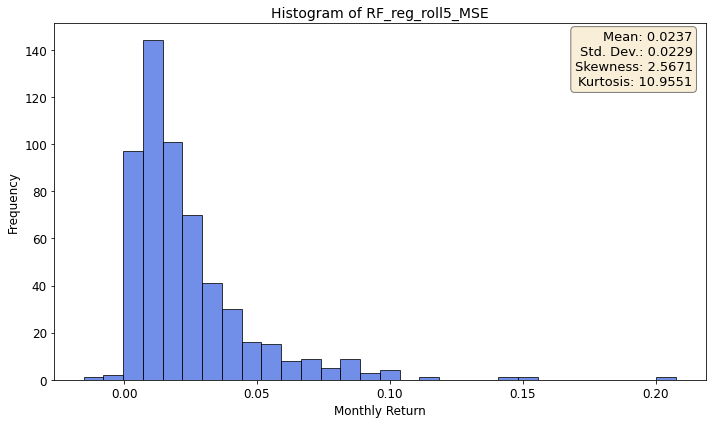

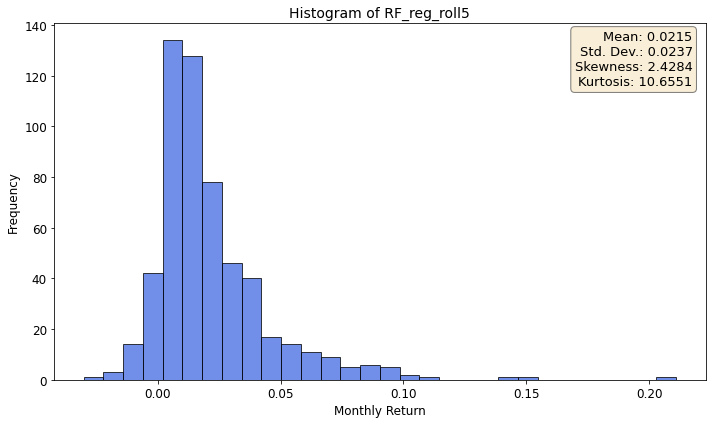

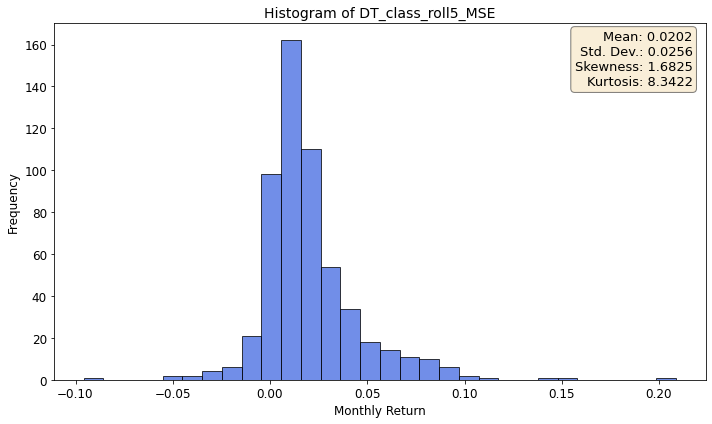

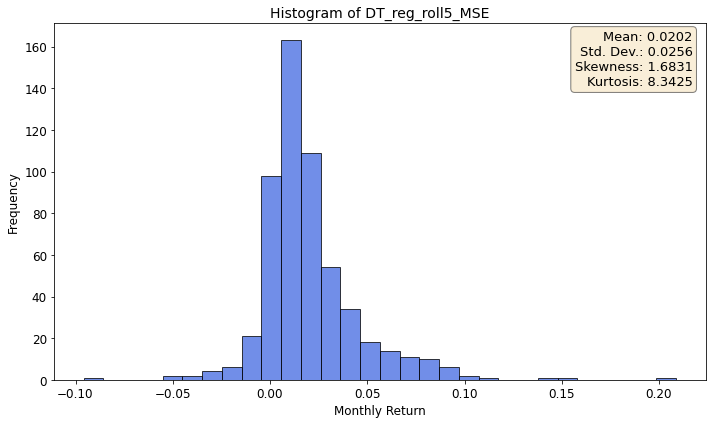

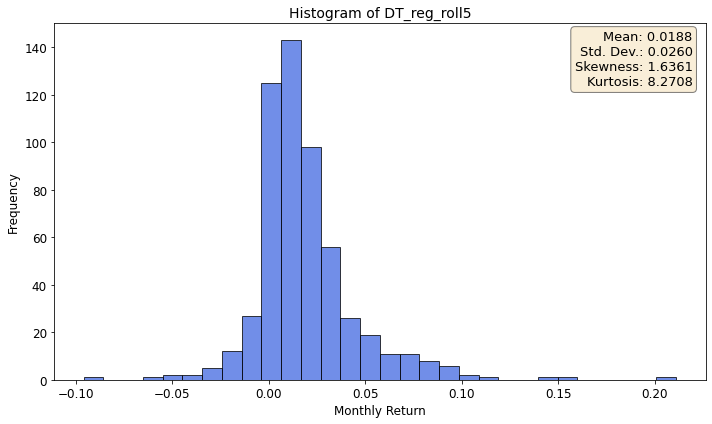

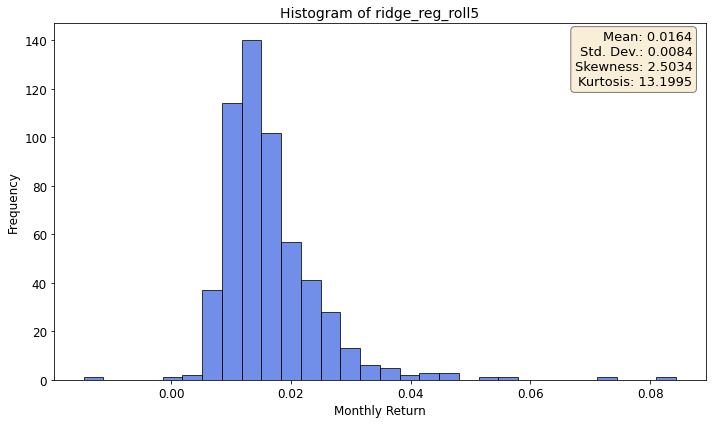

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming 'normal_ret' is your DataFrame and it's already loaded

def plot_histograms_separately(df, columns, bins=30, color='royalblue'):
    for column in columns:
        if column not in df.columns:
            print(f"Column '{column}' not found in DataFrame.")
            continue

        fig, ax = plt.subplots(figsize=(10, 6))
        values = df[column] 
        mean_val = values.mean()
        std_dev_val = values.std()
        skewness_val = skew(values)
        kurtosis_val = kurtosis(values)

        ax.hist(values, bins=bins, alpha=0.75, color=color, edgecolor='black')
        ax.set_title(f'Histogram of {column}', fontsize=14)
        ax.set_xlabel('Monthly Return', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)


        # Annotating the plot with statistical values
        stats_text = f'Mean: {mean_val:.4f}\nStd. Dev.: {std_dev_val:.4f}\nSkewness: {skewness_val:.4f}\nKurtosis: {kurtosis_val:.4f}'
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', fontsize=13, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.show()



selected_columns = [model[2:] for model in best_models]

plot_histograms_separately(normal_ret, selected_columns)


In [54]:
# for each column, calculate the average of the column and store in a new DataFrame

avg_ret = normal_ret.mean()

# rename the column to 'avg_ret' and index to 'model'
avg_ret = avg_ret.to_frame().reset_index()
avg_ret.columns = ['model', 'avg_ret']

# round the values in the 'avg_ret' column to 3 decimal places
avg_ret['avg_ret'] = avg_ret['avg_ret'].round(3)


avg_ret.head()

<ipython-input-54-fcce1330845f>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  avg_ret = normal_ret.mean()


,model,avg_ret
0,ols_default,0.016
1,ridge_reg_roll5,0.016
2,lasso_reg_roll5,0.005
3,DT_reg_roll5,0.019
4,RF_reg_roll5,0.022


In [55]:
excess_ret = normal_ret.copy()

# Calculate excess return (i.e. subtract the RF column) for columns in 'models' list
for model in models:
    excess_ret[model] = excess_ret[model] - excess_ret['RF']


excess_ret.head()


,date,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
0,1976-01-31,0.025653,0.023763,-0.081695,-0.005691,-0.005691,0.1216,0.035028,0.016337,-0.005691,0.018415,0.016971,0.026143,-0.081695,-0.005691,-0.004939,-0.006733,-0.005691,0.024128,-0.006026,0.1216,0.0481,0.0863,0.0047,0.0634,0.0863,-0.0179,0.0228
1,1976-02-29,0.012431,0.017265,0.019025,0.019850,0.019839,0.0032,0.016382,0.017013,0.020647,0.016035,0.020470,0.012124,0.019025,0.019850,0.020519,0.000569,0.019850,0.017486,0.000288,0.0032,0.0706,0.0587,0.0034,0.0799,0.0587,-0.0264,0.0387
2,1976-03-31,0.007587,0.006907,0.001061,-0.002174,-0.002175,0.0232,0.007072,0.007845,0.008497,0.008357,0.000478,0.007215,0.001061,-0.002174,0.002148,-0.001693,-0.002174,0.006069,-0.001628,0.0232,-0.0116,-0.0012,0.0040,-0.0138,-0.0012,-0.0033,0.0096
3,1976-04-30,0.006921,0.006654,-0.000577,0.020730,0.020730,-0.0149,0.004551,0.003577,0.020604,0.007972,0.003525,0.006562,-0.000577,0.020730,0.020634,0.003555,0.020730,0.007378,-0.001443,-0.0149,-0.0011,-0.0016,0.0042,0.0008,-0.0016,0.0040,-0.0110
4,1976-05-31,0.014012,0.014064,0.001755,0.017390,0.022230,-0.0134,0.014287,0.011581,0.022451,0.009242,0.011824,0.014165,0.001755,0.017390,0.022393,0.010931,0.017390,0.010977,0.000280,-0.0134,-0.0123,-0.0136,0.0037,-0.0110,-0.0136,0.0246,-0.0141


In [56]:
# save the excess_ret DataFrame to a .dta file
excess_ret.to_csv('base_excess_ret.csv', index=False)

### Calculating Sharpe Ratios and Abnormal Returns


In [57]:
import statsmodels.api as sm

In [58]:
models = excess_ret.columns
models = models.drop(['date', 'Mkt', 'SMB3', 'HML3', 'RF', 'SMB5', 'HML5', 'RMW5', 'CMA5', 'Mkt-RF'])

# Initialize DataFrame to hold all results
backtest = pd.DataFrame(columns=['Model', 'Ann_Sharpe', 'CAPM_a', 'CAPM_p', 'FF3_a', 'FF3_p', 'FF5_a', 'FF5_p'])

# Prepare X variables for CAPM and Three-Factor models outside the loop
X_capm = sm.add_constant(excess_ret['Mkt-RF'])  # CAPM
X_ff3 = sm.add_constant(excess_ret[['Mkt-RF', 'SMB3', 'HML3']])  # Three-Factor

# Drop rows with NaN values in Five-Factor model variables
X_ff5_clean = excess_ret[['Mkt-RF', 'SMB5', 'HML5', 'RMW5', 'CMA5']].dropna()
X_ff5 = sm.add_constant(X_ff5_clean)  # Five-Factor

for model in models:
    # Assuming y might contain NaNs, drop them for alignment
    y = excess_ret[model]
    
    # Ensure alignment of y with each X variable
    # CAPM model fit
    aligned_X_capm = X_capm.loc[y.index]
    capm_results = sm.OLS(y, aligned_X_capm).fit()
    
    # Three-Factor model fit
    aligned_X_ff3 = X_ff3.loc[y.index]
    ff3_results = sm.OLS(y, aligned_X_ff3).fit()
    
    # Five-Factor model fit, ensuring alignment with the clean X_ff5 index
    aligned_X_ff5 = X_ff5.loc[X_ff5.index.intersection(y.index)]
    y_aligned_ff5 = y.loc[aligned_X_ff5.index]
    ff5_results = sm.OLS(y_aligned_ff5, aligned_X_ff5).fit()
    
    # Calculate and round the annualized Sharpe ratio
    mean_excess_return = y.mean()
    std_dev_excess_returns = y.std()
    ann_sharpe = round((mean_excess_return/std_dev_excess_returns) * np.sqrt(12), 2)  # Square root of 12 for monthly data
    
    # Round alpha and p-values
    capm_a = round(capm_results.params[0], 3)
    capm_p = round(capm_results.pvalues[0], 3)
    ff3_a = round(ff3_results.params[0], 3)
    ff3_p = round(ff3_results.pvalues[0], 3)
    ff5_a = round(ff5_results.params[0], 3)
    ff5_p = round(ff5_results.pvalues[0], 3)
    
    # Append results to the DataFrame
    backtest = backtest.append({
        'Model': model,
        'Ann_Sharpe': ann_sharpe,
        'CAPM_a': capm_a,
        'CAPM_p': capm_p,
        'FF3_a': ff3_a,
        'FF3_p': ff3_p,
        'FF5_a': ff5_a,
        'FF5_p': ff5_p,
    }, ignore_index=True)


# drop the row where the model is 'Mkt'
#backtest = backtest[backtest['Model'] != 'Mkt']

# Display the compiled results
backtest.head(10)


,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p
0,ols_default,0.545,0.012,0.0,0.012,0.0,0.012,0.0
1,ridge_reg_roll5,0.537,0.012,0.0,0.013,0.0,0.013,0.0
2,lasso_reg_roll5,0.071,0.002,0.0,0.002,0.0,0.002,0.0
3,DT_reg_roll5,0.204,0.019,0.0,0.019,0.0,0.019,0.0
4,RF_reg_roll5,0.264,0.021,0.0,0.021,0.0,0.021,0.0
5,base_ols_default,0.526,0.012,0.0,0.012,0.0,0.013,0.0
6,ridge_clas_roll5,0.364,0.008,0.0,0.008,0.0,0.009,0.0
7,DT_class_roll5,0.050,0.010,0.0,0.010,0.0,0.010,0.0
8,RF_class_roll5,0.454,0.012,0.0,0.013,0.0,0.013,0.0
9,lasso_clas_roll5,0.178,0.003,0.0,0.003,0.0,0.003,0.0


In [59]:
backtest.sort_values('Ann_Sharpe', ascending=False, inplace=True)

In [60]:
# round the total_cum_logret column to 4 decimal places
final_log_ret_df['total_cum_logret'] = final_log_ret_df['total_cum_logret'].round(3)

# if the value in the column "model" of final_log_ret_df starts with "l_" then remove the "l_" from the value
final_log_ret_df['model'] = final_log_ret_df['model'].apply(lambda x: x[2:] if x.startswith('l_') else x)

# merge with avg_ret DataFrame on the 'model' column
backtest = backtest.merge(avg_ret, left_on='Model', right_on='model', how='left')

# remove the model column
backtest.drop('model', axis=1, inplace=True)

# drop row where Model is ols_default_x	
backtest = backtest[backtest['Model'] != 'ols_default_x']


backtest.head(50)



,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret
0,ols_default,0.545,0.012,0.0,0.012,0.0,0.012,0.0,0.016
1,ridge_reg_roll5_MSE,0.538,0.012,0.0,0.012,0.0,0.012,0.0,0.016
2,ridge_reg_roll5,0.537,0.012,0.0,0.013,0.0,0.013,0.0,0.016
3,base_ols_default,0.526,0.012,0.0,0.012,0.0,0.013,0.0,0.016
4,RF_class_roll5,0.454,0.012,0.0,0.013,0.0,0.013,0.0,0.016
5,ridge_clas_roll5,0.364,0.008,0.0,0.008,0.0,0.009,0.0,0.012
6,RF_class_roll5_MSE,0.349,0.010,0.0,0.010,0.0,0.010,0.0,0.013
7,RF_reg_roll5_MSE,0.304,0.023,0.0,0.024,0.0,0.023,0.0,0.024
8,RF_reg_roll5,0.264,0.021,0.0,0.021,0.0,0.021,0.0,0.022
9,DT_class_roll5_MSE,0.228,0.020,0.0,0.020,0.0,0.020,0.0,0.020


In [61]:
# merge the final_log_ret_df and backtest DataFrames on the 'model' column
backtest = backtest.merge(final_log_ret_df, left_on='Model', right_on='model', how='left')

# remove the model column
backtest.drop('model', axis=1, inplace=True)

backtest.head(10)

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Metric,Algorithm
0,ols_default,0.545,0.012,0.0,0.012,0.0,0.012,0.0,0.016,8.912,reg,acc,ols
1,ridge_reg_roll5_MSE,0.538,0.012,0.0,0.012,0.0,0.012,0.0,0.016,8.927,reg,mse,ridge
2,ridge_reg_roll5,0.537,0.012,0.0,0.013,0.0,0.013,0.0,0.016,9.091,reg,acc,ridge
3,base_ols_default,0.526,0.012,0.0,0.012,0.0,0.013,0.0,0.016,9.077,reg,acc,ols
4,RF_class_roll5,0.454,0.012,0.0,0.013,0.0,0.013,0.0,0.016,8.593,class,acc,RF
5,ridge_clas_roll5,0.364,0.008,0.0,0.008,0.0,0.009,0.0,0.012,6.693,class,acc,ridge
6,RF_class_roll5_MSE,0.349,0.010,0.0,0.010,0.0,0.010,0.0,0.013,7.192,class,mse,RF
7,RF_reg_roll5_MSE,0.304,0.023,0.0,0.024,0.0,0.023,0.0,0.024,12.943,reg,mse,RF
8,RF_reg_roll5,0.264,0.021,0.0,0.021,0.0,0.021,0.0,0.022,11.773,reg,acc,RF
9,DT_class_roll5_MSE,0.228,0.020,0.0,0.020,0.0,0.020,0.0,0.020,11.030,class,mse,DT


In [62]:
# save the backtest into parquet
backtest.to_parquet('backtest.parquet')

In [63]:
# sort the backtest using Ann_sharpe in descending order
backtest.sort_values('Ann_Sharpe', ascending=False, inplace=True)
backtest.head(30)

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Metric,Algorithm
0,ols_default,0.545,0.012,0.0,0.012,0.0,0.012,0.0,0.016,8.912,reg,acc,ols
1,ridge_reg_roll5_MSE,0.538,0.012,0.0,0.012,0.0,0.012,0.0,0.016,8.927,reg,mse,ridge
2,ridge_reg_roll5,0.537,0.012,0.0,0.013,0.0,0.013,0.0,0.016,9.091,reg,acc,ridge
3,base_ols_default,0.526,0.012,0.0,0.012,0.0,0.013,0.0,0.016,9.077,reg,acc,ols
4,RF_class_roll5,0.454,0.012,0.0,0.013,0.0,0.013,0.0,0.016,8.593,class,acc,RF
5,ridge_clas_roll5,0.364,0.008,0.0,0.008,0.0,0.009,0.0,0.012,6.693,class,acc,ridge
6,RF_class_roll5_MSE,0.349,0.010,0.0,0.010,0.0,0.010,0.0,0.013,7.192,class,mse,RF
7,RF_reg_roll5_MSE,0.304,0.023,0.0,0.024,0.0,0.023,0.0,0.024,12.943,reg,mse,RF
8,RF_reg_roll5,0.264,0.021,0.0,0.021,0.0,0.021,0.0,0.022,11.773,reg,acc,RF
10,DT_reg_roll5_MSE,0.228,0.020,0.0,0.020,0.0,0.020,0.0,0.020,11.026,reg,mse,DT


In [71]:
# print the average annualized Sharpe ratio for each type and method
print(backtest.groupby(['Type', 'Metric'])['Ann_Sharpe'].mean())
print(backtest['Ann_Sharpe'].mean())

print(backtest['CAPM_a'].mean())

Type   Metric
class  acc       0.261500
       mse       0.216500
reg    acc       0.357833
       mse       0.285250
Name: Ann_Sharpe, dtype: float64
0.28888888888888886
0.011277777777777779


In [65]:
# Convert categorical variables into dummy variables
backtest_dummies = pd.get_dummies(backtest, columns=['Type', 'Metric', 'Algorithm'])

# Define the base formula components excluding CAPM, FF3, and FF5 related columns
base_formula_components = ['Type', 'Metric', 'Algorithm']

# Construct the formula for Sharpe Ratio regression
formula_sharpe = 'Ann_Sharpe ~ ' + ' + '.join([f'C({component})' for component in base_formula_components])

# Construct the formula for Total Cumulative Logarithmic Return regression
formula_logret = 'total_cum_logret ~ ' + ' + '.join([f'C({component})' for component in base_formula_components])

# Perform the regression for Sharpe Ratio
model_sharpe = smf.ols(formula=formula_sharpe, data=backtest).fit()

# Perform the regression for Total Cumulative Logarithmic Return
model_logret = smf.ols(formula=formula_logret, data=backtest).fit()

# Print the summary tables for both regressions
print("Regression for Sharpe Ratio:\n", model_sharpe.summary())
print("\nRegression for Total Cumulative Logarithmic Return:\n", model_logret.summary())


Regression for Sharpe Ratio:
                             OLS Regression Results                            
Dep. Variable:             Ann_Sharpe   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     5.805
Date:                Wed, 06 Mar 2024   Prob (F-statistic):            0.00605
Time:                        17:12:00   Log-Likelihood:                 19.383
No. Observations:                  18   AIC:                            -24.77
Df Residuals:                      11   BIC:                            -18.53
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [66]:
backtest = backtest.merge(metrics_df[['Accuracy', 'MAE', 'MSE']], left_on='Model', right_index=True, how='left')
backtest.rename(columns={'Accuracy': 'Acc_tot', 'MAE': 'MAE_tot', 'MSE': 'MSE_tot'}, inplace=True)
backtest = backtest.merge(metrics_decile[['Accuracy', 'MAE', 'MSE']], left_on='Model', right_index=True, how='left')
backtest.rename(columns={'Accuracy': 'Acc_dec', 'MAE': 'MAE_dec', 'MSE': 'MSE_dec'}, inplace=True)
backtest.head()

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Metric,Algorithm,Acc_tot,MAE_tot,MSE_tot,Acc_dec,MAE_dec,MSE_dec
0,ols_default,0.545,0.012,0.0,0.012,0.0,0.012,0.0,0.016,8.912,reg,acc,ols,0.867895,0.333954,0.140638,0.963131,0.238534,0.107924
1,ridge_reg_roll5_MSE,0.538,0.012,0.0,0.012,0.0,0.012,0.0,0.016,8.927,reg,mse,ridge,0.843058,0.336490,0.147818,0.955284,0.239084,0.115528
2,ridge_reg_roll5,0.537,0.012,0.0,0.013,0.0,0.013,0.0,0.016,9.091,reg,acc,ridge,0.826384,0.345800,0.152285,0.953734,0.236883,0.106889
3,base_ols_default,0.526,0.012,0.0,0.012,0.0,0.013,0.0,0.016,9.077,reg,acc,ols,0.833637,0.348917,0.150501,0.951408,0.248550,0.108347
4,RF_class_roll5,0.454,0.012,0.0,0.013,0.0,0.013,0.0,0.016,8.593,class,acc,RF,0.967115,0.111896,0.032796,0.993133,0.036936,0.006691


In [67]:
# OLS: Ann_Sharpe ~ Acc_tot
model_acc_tot = smf.ols(formula='Ann_Sharpe ~ Acc_tot', data=backtest).fit()

# OLS: Ann_Sharpe ~ Acc_dec
model_acc_dec = smf.ols(formula='Ann_Sharpe ~ Acc_dec', data=backtest).fit()

# OLS: Ann_Sharpe ~ MSE_tot
model_mse_tot = smf.ols(formula='Ann_Sharpe ~ MSE_tot', data=backtest).fit()

# OLS: Ann_Sharpe ~ MSE_dec
model_mse_dec = smf.ols(formula='Ann_Sharpe ~ MSE_dec', data=backtest).fit()

# print the summary tables for both regressions
print("Regression for Ann_Sharpe ~ Acc_tot:\n", model_acc_tot.summary())
print("\nRegression for Ann_Sharpe ~ Acc_dec:\n", model_acc_dec.summary())
print("\nRegression for Ann_Sharpe ~ MSE_tot:\n", model_mse_tot.summary())
print("\nRegression for Ann_Sharpe ~ MSE_dec:\n", model_mse_dec.summary())



c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Regression for Ann_Sharpe ~ Acc_tot:
                             OLS Regression Results                            
Dep. Variable:             Ann_Sharpe   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.3839
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.544
Time:                        17:12:00   Log-Likelihood:                 6.7532
No. Observations:                  18   AIC:                            -9.506
Df Residuals:                      16   BIC:                            -7.726
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [68]:
# OLS: total_cum_logret ~ Acc_tot
model_logret_acc_tot = smf.ols(formula='total_cum_logret ~ Acc_tot', data=backtest).fit()

# OLS: total_cum_logret ~ Acc_dec
model_logret_acc_dec = smf.ols(formula='total_cum_logret ~ Acc_dec', data=backtest).fit()

# OLS: total_cum_logret ~ MSE_tot
model_logret_mse_tot = smf.ols(formula='total_cum_logret ~ MSE_tot', data=backtest).fit()

# OLS: total_cum_logret ~ MSE_dec
model_logret_mse_dec = smf.ols(formula='total_cum_logret ~ MSE_dec', data=backtest).fit()

# print the summary tables for both regressions
print("Regression for total_cum_logret ~ Acc_tot:\n", model_logret_acc_tot.summary())
print("\nRegression for total_cum_logret ~ Acc_dec:\n", model_logret_acc_dec.summary())
print("\nRegression for total_cum_logret ~ MSE_tot:\n", model_logret_mse_tot.summary())
print("\nRegression for total_cum_logret ~ MSE_dec:\n", model_logret_mse_dec.summary())


Regression for total_cum_logret ~ Acc_tot:
                             OLS Regression Results                            
Dep. Variable:       total_cum_logret   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     3.260
Date:                Wed, 06 Mar 2024   Prob (F-statistic):             0.0898
Time:                        17:12:00   Log-Likelihood:                -45.489
No. Observations:                  18   AIC:                             94.98
Df Residuals:                      16   BIC:                             96.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
